In [2]:
# Packages:
import gc
import os
import re


import joblib
import pandas as pd
import openpyxl
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer



#----------------------------------------------------------------------------------------

file=("C:/Users/nikil/OneDrive/Desktop/Uni/M.Sc/Data Analytics/Project 3/Data/Final.Data.csv")
relevantcolumn = 'speechtext'

# Define %Sample to use
prob = 0.2

# Clusters:
cluster_groups = 5

# How many ngrams?
ngrams = 2

# List of banned words
bannedwords = ['canada', 'minister','people', 'hon', "friend", "speaker", "mr", "government", "man",
               "boy", "year", "states" , "house" , "party", "department", "committee", "province"]

# minimum length of speeches
lengthspeech = 1000

# Numbers:
numbers = r'[0-9]'

# Models:
model_path = 'Output/NLTK_Model_'+str(cluster_groups)+'.sav'    ## model
vectorizer_path = 'Output/NLTK_vectorizer_'+str(cluster_groups)+'.sav'    ## vectorizer
class_path = 'Output/NLTK_Clusters_'+str(cluster_groups)+'.csv'    ## model

# Model parameters
token = RegexpTokenizer('[a-zA-Z0-9]+')
vectorizer = TfidfVectorizer(lowercase=True,stop_words='english',ngram_range=(1,ngrams), tokenizer=token.tokenize)


#Define Stem Function
porter= PorterStemmer()
landcaster = LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


#CLEAN THIS FUNCTION
# Define a function that reads the data:
def load_data(file,wordcount):
    #arguments: (the file to load, the minimum amount of words each speech should have
    #load data and drop NA
    df = pd.read_csv(file)
    df = df[~df['speakeroldname'].isnull()]
    df = df[~df[relevantcolumn].isnull()]
    #extract year
    s = pd.Series(df['speechdate'])
    s2 = s.str.split(r"-",n=-1, expand=True)
    year = s2.iloc[:,0]
    year = pd.DataFrame(year)
    year.columns = ['year']
    #merge year into data
    document = pd.merge(df,year, left_index=True, right_index=True)
    document = document[['basepk',relevantcolumn,'year']]
    document = document.dropna()
    #drop duplicate rows
    document = document.drop_duplicates(subset=[relevantcolumn])
    #get speech length and drop everything that has less words than definded in wordcount (arg of function)
    document["speechlength"] = document[relevantcolumn].str.len()
    document = document.loc[document["speechlength"]>wordcount]
    gc.collect()
    del df
    return document


def clean_string(text, wordlist):
    #arguments (speech text and banned words)
    #tokenize -> split speech text into list of single words
    tokenized_word = word_tokenize(text)
    #take set of stopwords like (i , me , you ...) from package
    stop_words = set(stopwords.words("english"))
    filtered_list = []
    #Get all words that are not stop word or banned words and append them to filtered list
    for w in tokenized_word:
        if w not in stop_words and w not in wordlist:
            filtered_list.append(w)

    #filtered_list contains list with lots of individual strings

    #define word types we want to keep
    typeselect=['NOUN']
    #assigns to each word the word type and convert that into data frame
    #words is a list of touples (word, wordtype)
    words = nltk.pos_tag(filtered_list,tagset='universal')
    w = pd.DataFrame(words)
    w.columns =['word','type']
    #only take rows with words of certain word type
    rslt_df = w.loc[w['type'].isin(typeselect)]
    #ony take the word columns
    h = list(rslt_df['word'])
    # next line gets rid of individual strings and binds them together to one big string

    for word in h:
        porter.stem(word)
        landcaster.stem(word)
    sentence = ' '.join(h)
    return sentence

### Pre-processing
#load data
data = load_data(file,lengthspeech)
#take out speeches and convert it to data frame
doc = data[relevantcolumn]
smp = pd.DataFrame(doc)
#take subset for computational reasons
smp= smp.sample(n=int(prob*len(smp)), random_state=1)
lendoc = len(smp)

#
for i in range(0,lendoc,1):
    #next three lines show us progress of the loop
    if i % 250 == 0:
        p = i/lendoc
        print('{:2.2%}'.format(p))
    #iterate over all speeches
    #take out speech number i and convert it to small letters
    smp.iat[i, 0] = smp.iat[i, 0].lower()
    #replace every number in the text with nothing
    smp.iat[i, 0] = re.sub(numbers,"",smp.iat[i, 0])
    #apply clean string function previously defined
    smp.iat[i, 0] = clean_string(smp.iat[i, 0],bannedwords)


print("Training Models")
#Convert text data in numerical data for statistical model
#vectorizer defined in line 50
tfidf = vectorizer.fit(smp[relevantcolumn])
# save vectorizer
joblib.dump(tfidf,vectorizer_path)
#transfrom output in matrix of numarical values
text_counts = vectorizer.fit_transform(smp[relevantcolumn])

## NOW DATA IS READY AND WE CAN APPLY CLUSTERING ALGORITHM

#CLUSTERING
# Training step
#define how many clusters you want (5)
true_k = cluster_groups
#define clustering algorithm
model = KMeans(n_clusters=true_k,init='k-means++', max_iter=300,n_init=10)
#run it on the data
model.fit(text_counts)
#save outfit
joblib.dump(model,model_path)

### What are the groups?
#get the coordinates of the center of each cluster and sort it
order_centroids = model.cluster_centers_.argsort()[:,::-1]

terms = vectorizer.get_feature_names()


#Lets get 20 most important words for each cluster
df=pd.DataFrame()
for i in range(0,true_k):
    wlist =[]
    #for each cluster, get 20 most important words
    for ind in order_centroids[i, :20]:
        #actually print out the word
        print('%s' % terms[ind])
        #append them to th elist
        wlist.append(terms[ind])
    #convert it to data frame
    df_app = pd.DataFrame(wlist)
    #add to final the result of each iteration
    final = pd.concat([df,df_app],axis=1)
    df = final

#rename columns with cluster groups
lst = list(range(0,true_k))
df.columns=lst
#save data
df.to_csv(class_path, index=False)


0.00%
1.57%
3.14%
4.72%
6.29%
7.86%
9.43%
11.01%
12.58%
14.15%
15.72%
17.30%
18.87%
20.44%
22.01%
23.59%
25.16%
26.73%
28.30%
29.88%
31.45%
33.02%
34.59%
36.17%
37.74%
39.31%
40.88%
42.46%
44.03%
45.60%
47.17%
48.75%
50.32%
51.89%
53.46%
55.03%
56.61%
58.18%
59.75%
61.32%
62.90%
64.47%
66.04%
67.61%
69.19%
70.76%
72.33%
73.90%
75.48%
77.05%
78.62%
80.19%
81.77%
83.34%
84.91%
86.48%
88.06%
89.63%
91.20%
92.77%
94.35%
95.92%
97.49%
99.06%
Training Models


C:\Users\nikil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\nikil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


member
time
country
members
matter
work
years
question
money
cent
way
order
trade
statement
day
service
fact
industry
information
number
tax
income
income tax
cent
taxation
taxes
budget
war
revenue
tax act
money
country
time
act
war tax
sales tax
finance
income war
sales
pay
act
section
board
amendment
council
parliament
legislation
provinces
time
pension
commission
order
court
power
member
law
matter
age
dominion
members
war
country
time
defence
air
world
service
nations
army
members
member
policy
veterans
force
effort
forces
years
war effort
services
peace
wheat
price
farmers
cents
prices
board
grain
market
products
farm
farmer
production
cent
agriculture
bushels
crop
wheat board
time
country
bushel


In [4]:

# So far we have used the speech data to come up with 5 clusters


# Predicting:
print("Opening Model")
vectorizer = joblib.load(open(vectorizer_path,'rb'))
model = joblib.load(open(model_path,'rb'))

# Preprocessing


### Pre-processing
data = load_data(file,lengthspeech)

doc = data[relevantcolumn]
smp = pd.DataFrame(doc)
lendoc = len(smp)

for i in range(0,lendoc,1):
    if i % 250 == 0:
        p = i/lendoc
        print('{:2.2%}'.format(p))
    smp.iat[i, 0] = smp.iat[i, 0].lower()
    smp.iat[i, 0] = re.sub(numbers,"",smp.iat[i, 0])
    smp.iat[i, 0] = clean_string(smp.iat[i, 0],bannedwords)

document = smp

lendoc = len(document[relevantcolumn])
text_counts = vectorizer.transform(document[relevantcolumn])
data["prediction"] = model.predict(text_counts)
#
#how are speaches distrubuted among clusters
print(data["prediction"].value_counts(normalize=True))

#lets split this up over time
#how much % of speeches fall in each cluster in a given year

Opening Model
0.00%
0.31%
0.63%
0.94%
1.26%
1.57%
1.89%
2.20%
2.52%
2.83%
3.14%
3.46%
3.77%
4.09%
4.40%
4.72%
5.03%
5.35%
5.66%
5.97%
6.29%
6.60%
6.92%
7.23%
7.55%
7.86%
8.18%
8.49%
8.81%
9.12%
9.43%
9.75%
10.06%
10.38%
10.69%
11.01%
11.32%
11.64%
11.95%
12.26%
12.58%
12.89%
13.21%
13.52%
13.84%
14.15%
14.47%
14.78%
15.09%
15.41%
15.72%
16.04%
16.35%
16.67%
16.98%
17.30%
17.61%
17.92%
18.24%
18.55%
18.87%
19.18%
19.50%
19.81%
20.13%
20.44%
20.76%
21.07%
21.38%
21.70%
22.01%
22.33%
22.64%
22.96%
23.27%
23.59%
23.90%
24.21%
24.53%
24.84%
25.16%
25.47%
25.79%
26.10%
26.42%
26.73%
27.04%
27.36%
27.67%
27.99%
28.30%
28.62%
28.93%
29.25%
29.56%
29.87%
30.19%
30.50%
30.82%
31.13%
31.45%
31.76%
32.08%
32.39%
32.71%
33.02%
33.33%
33.65%
33.96%
34.28%
34.59%
34.91%
35.22%
35.54%
35.85%
36.16%
36.48%
36.79%
37.11%
37.42%
37.74%
38.05%
38.37%
38.68%
38.99%
39.31%
39.62%
39.94%
40.25%
40.57%
40.88%
41.20%
41.51%
41.82%
42.14%
42.45%
42.77%
43.08%
43.40%
43.71%
44.03%
44.34%
44.66%
44.97%
45.28%
45.

In [22]:

# This is where mathias' code ends
#Preparing the data for plotting

#take out only year and prediction
dat_plot=data[["year", "prediction"]]
dat_plot.rename(columns={"year":"year", "prediction":"pred"}, inplace=True )


#Get prediction seperated by every year
by_year=dat_plot.groupby(by="year")
dat_plot=by_year["pred"].value_counts()
dat_plot=dat_plot.unstack(level=0)
dat_plot.fillna(0, inplace=True)

#Get share for each group in each year
plot_df=pd.DataFrame()
for year in dat_plot.columns:
    plot_df[f"{year}"]=dat_plot[year]/dat_plot[year].sum()

#reshape from wide to long
plot_df.reset_index(inplace=True)
plot_df=plot_df.melt(id_vars="pred")
plot_df.rename(columns={"pred":"pred","variable":"year", "value": "share" }, inplace=True)
plot_df

C:\Users\nikil\AppData\Local\Temp\ipykernel_7860\2674607805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_plot.rename(columns={"year":"year", "prediction":"pred"}, inplace=True )


,pred,year,share
0,0,1930,0.663789
1,1,1930,0.018127
2,2,1930,0.227018
3,3,1930,0.032369
4,4,1930,0.058697
...,...,...,...
95,0,1949,0.588795
96,1,1949,0.044656
97,2,1949,0.216456
98,3,1949,0.089518


pred
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: share, dtype: object

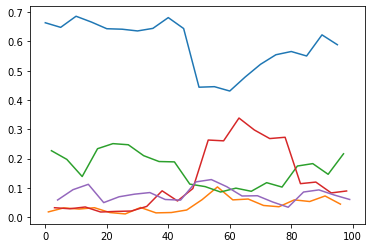

In [24]:
plot_df.groupby("pred")["share"].plot()

jump in red line is war cluster during war period
stress that in essay